In [1]:
#installing keras-tuner
!pip install keras-tuner


In [2]:
#importing necessary liabraries
import tensorflow as tf
import keras_tuner
import matplotlib.pyplot as plt
import numpy as np


In [3]:
#loading dataset and spliting it in test and train dataset
(x_train,y_train),(x_test,y_test)=tf.keras.datasets.fashion_mnist.load_data()

In [4]:
#check x_train shape
x_train.shape


(60000, 28, 28)

In [5]:
#setting the y_train data
set(y_train)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

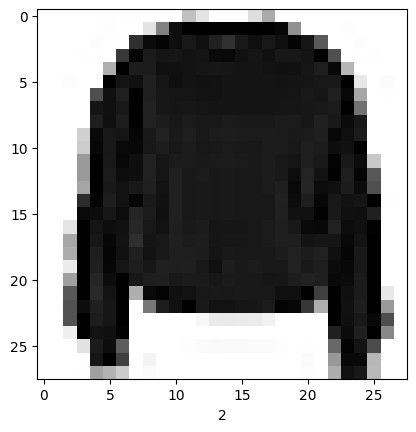

In [6]:
#checking a random element 7 and visualizing it
plt.imshow(x_train[7],cmap='binary')
plt.xlabel(y_train[7])
plt.show()

In [7]:
#creating model for the tuner

def create_model(hp):
  num_hidden_layers=1 #hidden layer
  num_units=8
  dropout_rate=0.1 #dropout rate
  learning_rate=0.01 #learning_Rate

  if hp:  #creating a hyperparmeter with choices
    num_hidden_layers=hp.Choice('num_hidden_layers',values=[1,2,3])
    num_units=hp.Choice('num_units',values=[8,16,32])
    dropout_rate=hp.Float('dropout_rate',min_value=0.1,max_value=0.5)
    learning_rate=hp.Float('learning_rate',min_value=0.0001,max_value=0.01)

  model=tf.keras.models.Sequential() #creating a sequential model

  model.add(tf.keras.layers.Flatten(input_shape=(28,28))) #flatten the layer
  model.add(tf.keras.layers.Lambda(lambda x: x/255.))

  for _ in range(0, num_hidden_layers):
    model.add(tf.keras.layers.Dense(num_units,activation='relu')) #relu activation
    model.add(tf.keras.layers.Dropout(dropout_rate))

  model.add(tf.keras.layers.Dense(10,activation='softmax')) #softmax activation

  model.compile(
      loss='sparse_categorical_crossentropy',
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      metrics=['accuracy']
  )
  return model

In [8]:
#creating model summary
create_model(None).summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 lambda (Lambda)             (None, 784)               0         
                                                                 
 dense (Dense)               (None, 8)                 6280      
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 10)                90        
                                                                 
Total params: 6,370
Trainable params: 6,370
Non-trainable params: 0
_________________________________________________________________


In [9]:
#defining a class with custom tuner using bayesian optimzation
class CustomTuner(keras_tuner.tuners.BayesianOptimization):
  def run_trial(self,trial, *args, **kwargs):
    kwargs['batch_size']=trial.hyperparameters.Int('batch_size',32,128,step=32) #giving batch size
    super(CustomTuner,self).run_trial(trial,*args,**kwargs)


In [10]:
#running a custom tuner
tuner=CustomTuner(
    create_model,
    objective='val_accuracy', #validation accuracy
    max_trials=20,           #defining max number of trials
    directory='logs',
    project_name='fashion_mnist',
    overwrite=True
)

In [11]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_hidden_layers (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2, 3], 'ordered': True}
num_units (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32], 'ordered': True}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': None, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'linear'}


In [ ]:
tuner.search(
    x_train,y_train,
    validation_data=(x_test,y_test),
    epochs=5,verbose=False
)

In [16]:
tuner.results_summary(1)

Results summary
Results in logs/fashion_mnist
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 00 summary
Hyperparameters:
num_hidden_layers: 3
num_units: 32
dropout_rate: 0.2788224629829768
learning_rate: 0.007921369981469363
batch_size: 32


In [17]:
model=tuner.get_best_models(num_models=1)[0]
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 lambda (Lambda)             (None, 784)               0         
                                                                 
 dense (Dense)               (None, 32)                25120     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                1

In [18]:
fit = model.fit(
    x_train,y_train,
    validation_data=(x_test,y_test),
    epochs=20,batch_size=128,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3)]
)

Epoch 1/20
469/469 [==============================] - 5s 8ms/step - loss: 0.9465 - accuracy: 0.6242 - val_loss: 0.7221 - val_accuracy: 0.7125
Epoch 2/20
469/469 [==============================] - 2s 5ms/step - loss: 0.9127 - accuracy: 0.6457 - val_loss: 0.7475 - val_accuracy: 0.6773
Epoch 3/20
469/469 [==============================] - 3s 7ms/step - loss: 0.9110 - accuracy: 0.6484 - val_loss: 0.7526 - val_accuracy: 0.6927
Epoch 4/20
469/469 [==============================] - 3s 6ms/step - loss: 0.9071 - accuracy: 0.6506 - val_loss: 0.6925 - val_accuracy: 0.7266
Epoch 5/20
469/469 [==============================] - 2s 5ms/step - loss: 0.9000 - accuracy: 0.6561 - val_loss: 0.7285 - val_accuracy: 0.7210
Epoch 6/20
469/469 [==============================] - 3s 5ms/step - loss: 0.8954 - accuracy: 0.6563 - val_loss: 0.7716 - val_accuracy: 0.6764
Epoch 7/20
469/469 [==============================] - 3s 5ms/step - loss: 0.8855 - accuracy: 0.6623 - val_loss: 0.6952 - val_accuracy: 0.7192
